In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow import keras

my_model_path = "drive/MyDrive/Colab Notebooks/cat_vs_dogs_revise_1.keras"
model = keras.models.load_model(my_model_path)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 180, 180, 16)      432       
                                                                 
 batch_normalization_16 (Bat  (None, 180, 180, 16)     64        
 chNormalization)                                                
                                                                 
 activation_16 (Activation)  (None, 180, 180, 16)      0         
                                                           

In [ ]:
import numpy as np

img_path = keras.utils.get_file(
    fname="cat.jpg",
    origin="https://img-datasets.s3.amazonaws.com/cat.jpg"
)

def get_img_array(img_path, target_size):
  img = keras.utils.load_img(
      img_path, target_size=target_size
  )
  array = keras.utils.img_to_array(img)
  array = np.expand_dims(array, axis=0)
  return array

img_tensor = get_img_array(img_path, (180, 180))

80329/80329 [==============================] - 0s 0us/step


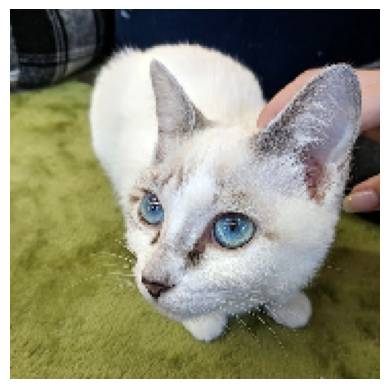

In [ ]:
import matplotlib.pyplot as plt

plt.axis('off')
plt.imshow(img_tensor[0].astype('uint8'))
plt.show()

In [ ]:
from tensorflow.keras import layers

layer_outputs = []
layer_names = []
for layer in model.layers:
  if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
    layer_outputs.append(layer.output)
    layer_names.append(layer.name)
  activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)

In [ ]:
activations = activation_model.predict(img_tensor)

1/1 [==============================] - 1s 554ms/step


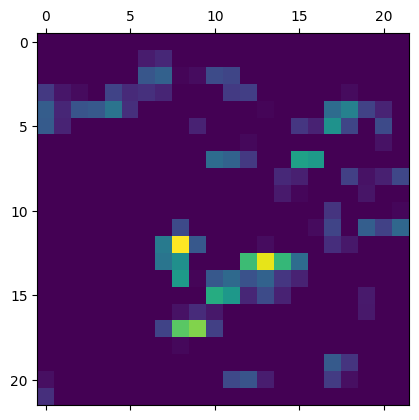

In [ ]:
plt.matshow(activations[8][0, :, :, 62], cmap="viridis")
plt.show()

In [39]:
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
  n_features = layer_activation.shape[-1]
  size = layer_activation.shape[1]
  n_cols = n_features // images_per_row
  display_grid = np.zeros(((size + 1) * n_cols - 1, images_per_row * (size + 1) - 1))

  for col in range(n_cols):
    for row in range(images_per_row):
      channel_index = col * images_per_row + row
      channel_image = layer_activation[0, :, :, channel_index].copy()
      if channel_image.sum() != 0:
        channel_image -= channel_image.mean()
        channel_image /= channel_image.std()
        channel_image *= 64
        channel_image += 128
      channel_image = np.clip(channel_image, 0, 255).astype('uint8')
      display_grid[
          col * (size + 1): (col + 1) * size + col,
          row * (size + 1): (row + 1) * size + row
      ] = channel_image

  scale = 1./size
  plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))

  plt.title(layer_name)
  plt.grid(False)
  plt.axis('off')
  plt.imshow(display_grid, aspect="auto", cmap="viridis")

Output hidden; open in https://colab.research.google.com to view.

In [40]:
model = keras.applications.xception.Xception(
    weights="imagenet",
    include_top=False
)

83683744/83683744 [==============================] - 1s 0us/step


In [42]:
for layer in model.layers:
  if isinstance(layer, (keras.layers.Conv2D, keras.layers.SeparableConv2D)):
    print(layer.name)

block1_conv1
block1_conv2
block2_sepconv1
block2_sepconv2
conv2d
block3_sepconv1
block3_sepconv2
conv2d_1
block4_sepconv1
block4_sepconv2
conv2d_2
block5_sepconv1
block5_sepconv2
block5_sepconv3
block6_sepconv1
block6_sepconv2
block6_sepconv3
block7_sepconv1
block7_sepconv2
block7_sepconv3
block8_sepconv1
block8_sepconv2
block8_sepconv3
block9_sepconv1
block9_sepconv2
block9_sepconv3
block10_sepconv1
block10_sepconv2
block10_sepconv3
block11_sepconv1
block11_sepconv2
block11_sepconv3
block12_sepconv1
block12_sepconv2
block12_sepconv3
block13_sepconv1
block13_sepconv2
conv2d_3
block14_sepconv1
block14_sepconv2


In [58]:
layer_name = "block10_sepconv1"
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.input, outputs=layer.output)

In [44]:
activation = feature_extractor(
    keras.applications.xception.preprocess_input(img_tensor)
)

In [59]:
import tensorflow as tf

def compute_loss(image, filter_index):
  activation = feature_extractor(image)
  filter_activation = activation[:, 2:-2, 2:-2, filter_index]
  return tf.reduce_mean(filter_activation)

In [60]:
@tf.function
def gradient_ascent_step(image, filter_index, learning_rate):
  with tf.GradientTape() as tape:
    tape.watch(image)
    loss = compute_loss(image, filter_index)
  grads = tape.gradient(loss, image)
  grads = tf.math.l2_normalize(grads)
  image += learning_rate * grads
  return image

In [61]:
img_width = 200
img_height = 200
def generate_filter_pattern(filter_index):
  iterations = 30
  learning_rate = 10.
  image = tf.random.uniform(
      minval=0.4,
      maxval=0.6,
      shape=(1, img_width, img_height, 3)
  )
  for i in range(iterations):
    image = gradient_ascent_step(image, filter_index, learning_rate)
  return image[0].numpy()

In [62]:
def deprocess_image(image):
  image -= image.mean()
  image /= image.std()
  image *= 64
  image += 128
  image = np.clip(image, 0, 255).astype('uint8')
  image = image[25:-25, 25:-25, :]
  return image

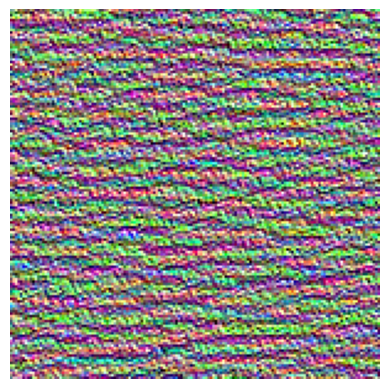

In [52]:
plt.axis('off')
plt.imshow(deprocess_image(generate_filter_pattern(filter_index=2)))
plt.show()

In [63]:
all_images = []
for filter_index in range(64):
  print(f"{filter_index}번 필터 처리중")
  image = deprocess_image(
      generate_filter_pattern(filter_index)
  )
  all_images.append(image)


margin = 5
n = 8
cropped_width = img_width - 25*2
cropped_height = img_height - 25*2
width = n*cropped_width + (n-1) * margin
height = n*cropped_height + (n-1) * margin
stitched_filters = np.zeros((width, height, 3))

0번 필터 처리중
1번 필터 처리중
2번 필터 처리중
3번 필터 처리중
4번 필터 처리중
5번 필터 처리중
6번 필터 처리중
7번 필터 처리중
8번 필터 처리중
9번 필터 처리중
10번 필터 처리중
11번 필터 처리중
12번 필터 처리중
13번 필터 처리중
14번 필터 처리중
15번 필터 처리중
16번 필터 처리중
17번 필터 처리중
18번 필터 처리중
19번 필터 처리중
20번 필터 처리중
21번 필터 처리중
22번 필터 처리중
23번 필터 처리중
24번 필터 처리중
25번 필터 처리중
26번 필터 처리중
27번 필터 처리중
28번 필터 처리중
29번 필터 처리중
30번 필터 처리중
31번 필터 처리중
32번 필터 처리중
33번 필터 처리중
34번 필터 처리중
35번 필터 처리중
36번 필터 처리중
37번 필터 처리중
38번 필터 처리중
39번 필터 처리중
40번 필터 처리중
41번 필터 처리중
42번 필터 처리중
43번 필터 처리중
44번 필터 처리중
45번 필터 처리중
46번 필터 처리중
47번 필터 처리중
48번 필터 처리중
49번 필터 처리중
50번 필터 처리중
51번 필터 처리중
52번 필터 처리중
53번 필터 처리중
54번 필터 처리중
55번 필터 처리중
56번 필터 처리중
57번 필터 처리중
58번 필터 처리중
59번 필터 처리중
60번 필터 처리중
61번 필터 처리중
62번 필터 처리중
63번 필터 처리중


In [64]:
for i in range(n):
  for j in range(n):
    image = all_images[i * n + j]
    stitched_filters[
        (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
        (cropped_height + margin) * j : (cropped_height + margin) * j + cropped_height,
        :
    ] = image


keras.utils.save_img(
    f"filters_for_layer_{layer_name}.png", stitched_filters
)

In [2]:
from tensorflow import keras

model = keras.applications.xception.Xception(weights="imagenet")

91884032/91884032 [==============================] - 3s 0us/step


In [4]:
import numpy as np

img_path = keras.utils.get_file(
    fname="elephant.jpg",
    origin="https://img-datasets.s3.amazonaws.com/elephant.jpg"
)

def get_img_array(img_path, target_size):
  img = keras.utils.load_img(img_path, target_size=target_size)
  array = keras.utils.img_to_array(img)
  array = np.expand_dims(array, axis=0)
  array = keras.applications.xception.preprocess_input(array)
  return array


img_array = get_img_array(img_path, (299, 299))

In [17]:
preds = model.predict(img_array)
print(keras.applications.xception.decode_predictions(preds, top=3)[0])

1/1 [==============================] - 1s 560ms/step
[('n02504458', 'African_elephant', 0.86993986), ('n01871265', 'tusker', 0.07695614), ('n02504013', 'Indian_elephant', 0.023541762)]


0.86993986

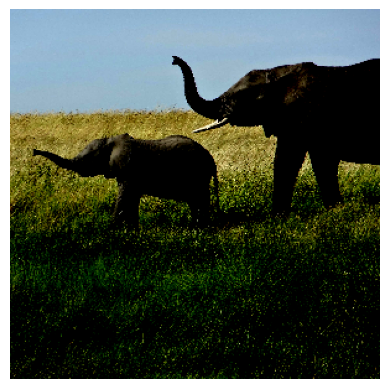

In [8]:
import matplotlib.pyplot as plt

plt.axis('off')
plt.imshow(img_array[0])

In [7]:
last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
    "avg_pool",
    "predictions"
]
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(inputs=model.inputs, outputs=last_conv_layer.output)

In [9]:
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
  x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)

In [18]:
import tensorflow as tf

with tf.GradientTape() as tape:
  last_conv_layer_output = last_conv_layer_model(img_array)
  tape.watch(last_conv_layer_output)
  preds = classifier_model(last_conv_layer_output)
  top_pred_index = tf.argmax(preds[0])
  top_class_channel = preds[:, top_pred_index]


grads = tape.gradient(top_class_channel, last_conv_layer_output)

tf.Tensor([0.86993986], shape=(1,), dtype=float32)


In [12]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(pooled_grads.shape[-1]):
  last_conv_layer_output[:, :, i] *= pooled_grads[i]
heatmap = np.mean(last_conv_layer_output, axis=-1)

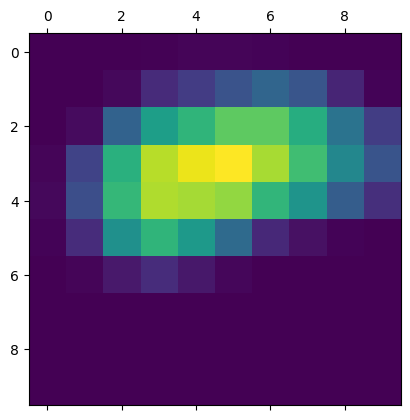

In [13]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [24]:
import matplotlib.cm as cm

img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)
heatmap = np.uint8(255 * heatmap)

jet = cm.get_cmap('jet')
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.utils.array_to_img(superimposed_img)

save_path = "elephant_cam.jpg"
superimposed_img.save(save_path)

<ipython-input-24-337982f1587f>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap('jet')
